# Accuracy experiments with BA-Shapes

## Load and visualize the data

In [1]:
import torch
import networkx as nx
from torch_geometric.utils import to_networkx, k_hop_subgraph
from attention_analysis_utils import k_hop_subgraph_modified, average_attention_heads
from torch_geometric.data import Data

dataset_name = 'Infection_50003d_sp'
model_name = f'GAT_infection_3L1H_sp'

# Load the data
data = torch.load(f'/workspace/{dataset_name}.pt',map_location ='cpu')
# Load the model
model = torch.load(f'/workspace/{model_name}.pt',map_location ='cpu')
model.eval()
# Get the attention weights
with torch.no_grad():
    out = model(data.x, data.edge_index, return_att=True)
    att = model.att 
    # att = average_attention_heads(att)
    # model.att = att

In [2]:
idx = 23
data.unique_solution_nodes[idx], data.unique_solution_explanations[idx] 

(97, [1187, 1930, 1490, 97])

In [3]:
# Label information: 0 = base nodes / 1 = Middle / 2 = Bottom / 3 = Top
# Visualizing k-hop subgraph from a target node

# 433, 482
target_idx = data.unique_solution_nodes[idx]
num_hops = 3

subset_orig, edge_index_orig, inv_orig, _ = k_hop_subgraph(node_idx=target_idx,
                                                                        num_hops=num_hops,
                                                                        edge_index=data.edge_index,
                                                                        relabel_nodes=False)

subset, edge_index, inv, _, _ = k_hop_subgraph_modified(node_idx=target_idx, 
                                                        num_hops=num_hops, 
                                                        edge_index=data.edge_index)

subgraph_data_orig = Data(x=data.x[subset_orig], 
                        edge_index=edge_index_orig,
                        y=data.y[subset_orig])
subgraph_data = Data(x=data.x[subset], 
                    edge_index=edge_index,
                    y=data.y[subset])

# Make a graph from the edge list (of tuples)
G_orig = nx.DiGraph() 
G_orig.add_edges_from(zip(edge_index_orig[0,:].tolist(), edge_index_orig[1,:].tolist()))
G = nx.DiGraph() 
G.add_edges_from(zip(edge_index[0,:].tolist(), edge_index[1,:].tolist()))

In [4]:
G_orig.edges()

OutEdgeView([(872, 3057), (3057, 1490), (1187, 1930), (1930, 1490), (1238, 3057), (1490, 97), (2382, 3057)])

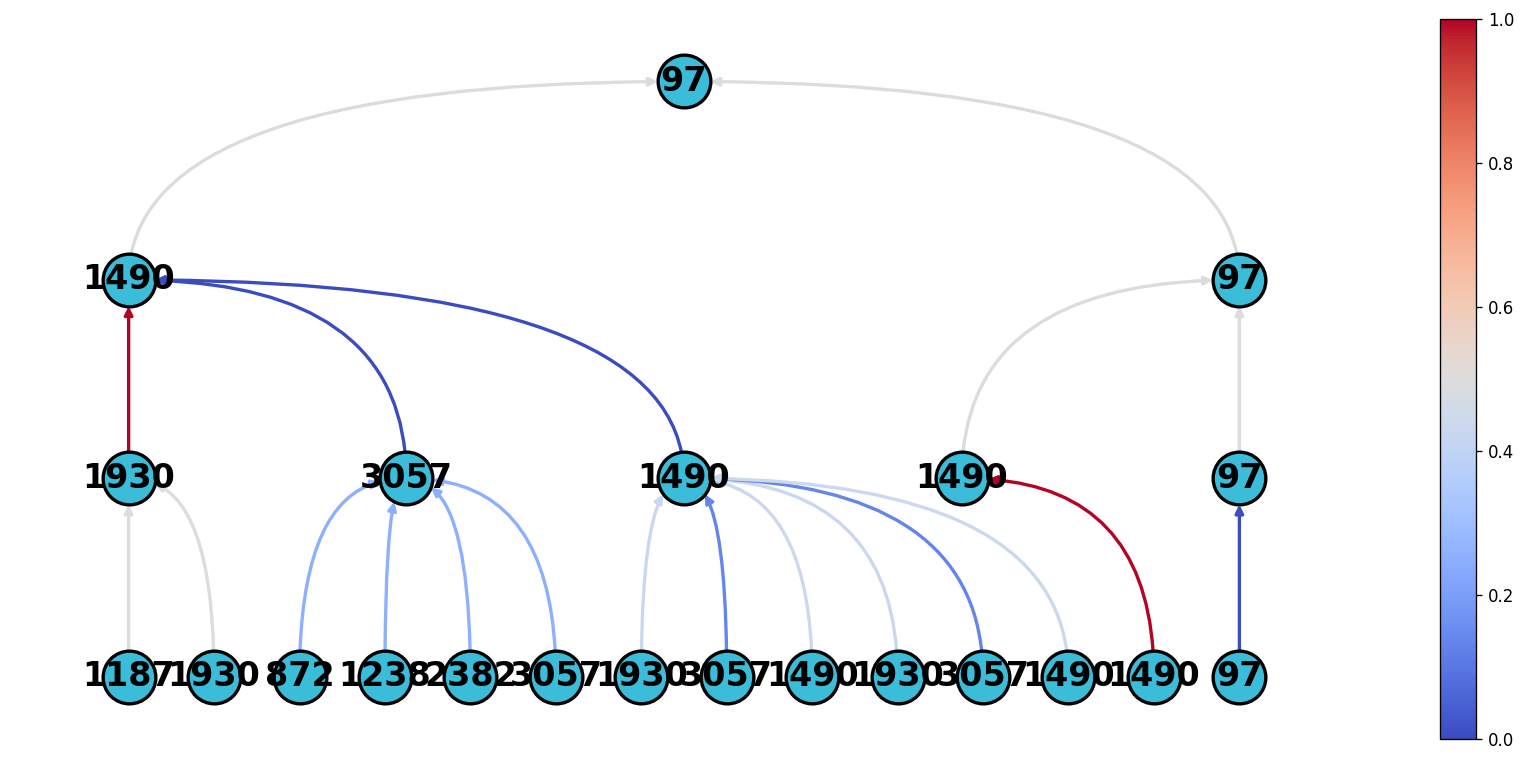

In [5]:
# Import the utility functions
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    get_attention_raw_dict_multihead,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
)

from torch_geometric.utils import get_num_hops
from visualization_utils import (
    visualize_computation_graph,
)
import torch


# num_layers = get_num_hops(model)
num_layers = 3

att_dict_raw = get_attention_raw_dict_multihead(model, data)
att_dict = process_attention_dict(att_dict_raw)
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_idx
)
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)
comp_graph_new = translate_comp_graph(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
)
layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
)
visualize_computation_graph(
    layer_att_dict=layer_att_dict,
    nodes_per_level_new=nodes_per_level_new,
    true_node_label=true_node_label,
    with_labels=True
)

/usr/local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


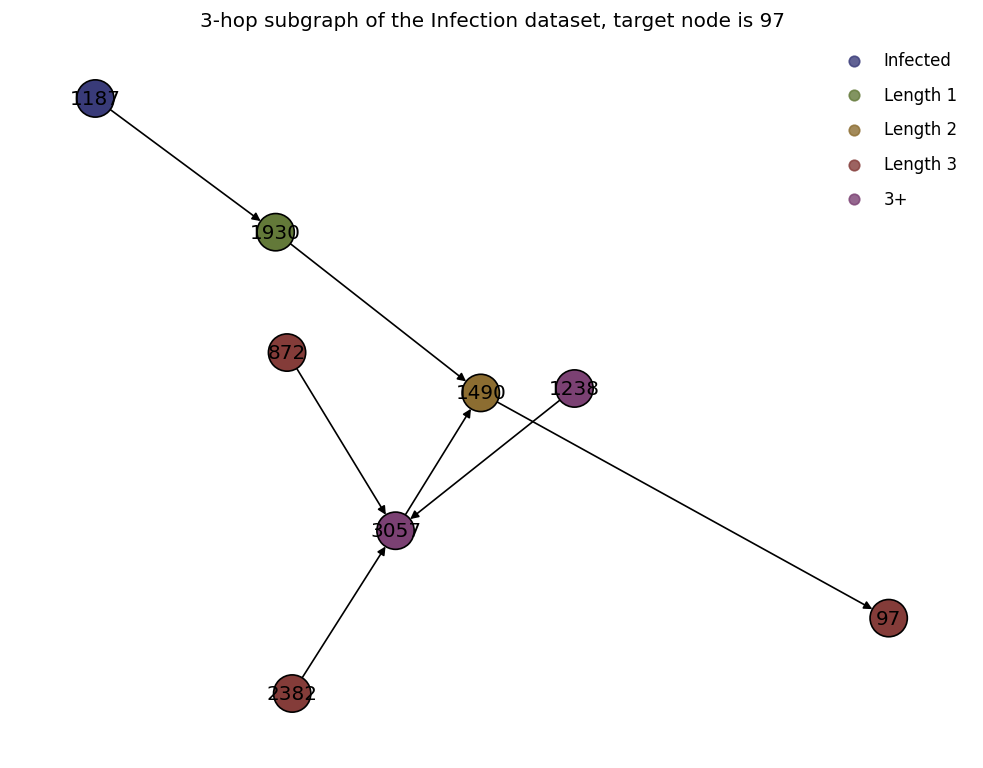

In [6]:
# Draw the subgraph
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6), dpi=120)
cmap = plt.cm.tab20b
pos = nx.spring_layout(G_orig, seed=42)
node_color = [cmap(data.y[nodes]/5) for nodes in G_orig]     
nx.draw(G_orig, 
        pos=pos,
        node_size=500,
        cmap=cmap,
        node_color=node_color,
        vmin=0,
        vmax=1,
        edgecolors="black",
        with_labels=True, 
        font_weight='regular')
plt.title(f"{num_hops}-hop subgraph of the Infection dataset, target node is {target_idx}")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0), label="Infected")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.2), label="Length 1")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.4), label="Length 2")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.6), label="Length 3")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.8), label="3+")
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc="upper right")

plt.show()

# Pink: Top
# Green: Middle
# Red: Bottom
# Blue: Base

In [7]:
# Before visualizing the other figures, we need to add self-loops to the graph
from torch_geometric.utils import add_self_loops

edge_index_self_loops = add_self_loops(data.edge_index)[0]

subset_loops, edge_index_loops, mapping_loops, edge_mask_loops = k_hop_subgraph(node_idx=target_idx, 
                                                        num_hops=num_hops, 
                                                        edge_index=edge_index_self_loops, 
                                                        relabel_nodes=True)

subgraph_data_loops = Data(x=data.x[subset_loops], 
                    edge_index=edge_index_self_loops, 
                    edge_mask=edge_mask_loops, 
                    y=data.y[subset_loops])

# Make list of tuples from edge_index_loops
edge_index_loops_list = edge_index_loops.t().tolist()

# Make a graph from the edge_index_loops_list
G_self_loops = nx.DiGraph()
G_self_loops.add_edges_from(edge_index_loops_list)

# Draw the subgraph with attention weights
# Get the attention weights from the first GAT layer
att_layer0 = att[0][1][edge_mask_loops].squeeze().tolist()
# Get the attention weights from the second GAT layer
att_layer1 = att[1][1][edge_mask_loops].squeeze().tolist()

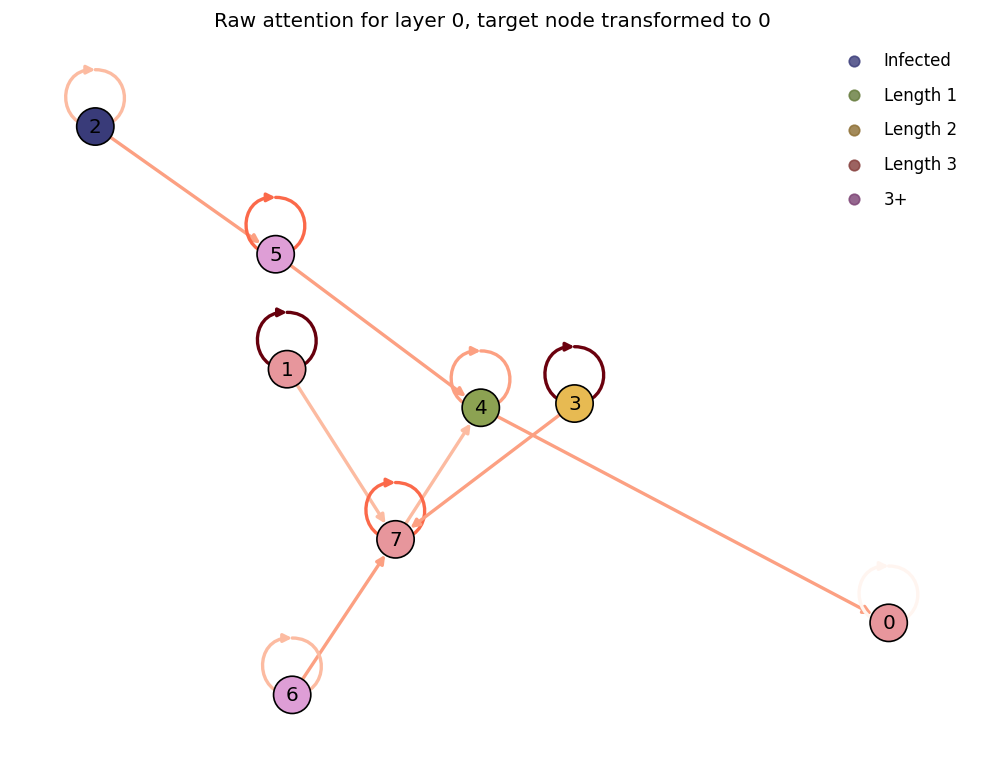

In [8]:
# Draw the graph with att_layer0 as edge weights
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(8, 6), dpi=120)
cmap = plt.cm.tab20b
edge_cmap = plt.cm.Reds
pos_loops = dict(zip(G_self_loops.nodes(), pos.values()))
nx.draw(G_self_loops, 
        pos=pos_loops,
        node_size=500,
        cmap=cmap,
        edge_color=edge_cmap(att_layer0),
        edge_vmin=0.0,
        edge_vmax=1.0,
        node_color=data.y[subset] / 5,
        edgecolors="black",
        with_labels=True, 
        width=2,
        font_weight='regular')
plt.title(f"Raw attention for layer 0, target node transformed to {mapping_loops.item()}")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0), label="Infected")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.2), label="Length 1")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.4), label="Length 2")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.6), label="Length 3")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.8), label="3+")
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc="upper right")
plt.show()

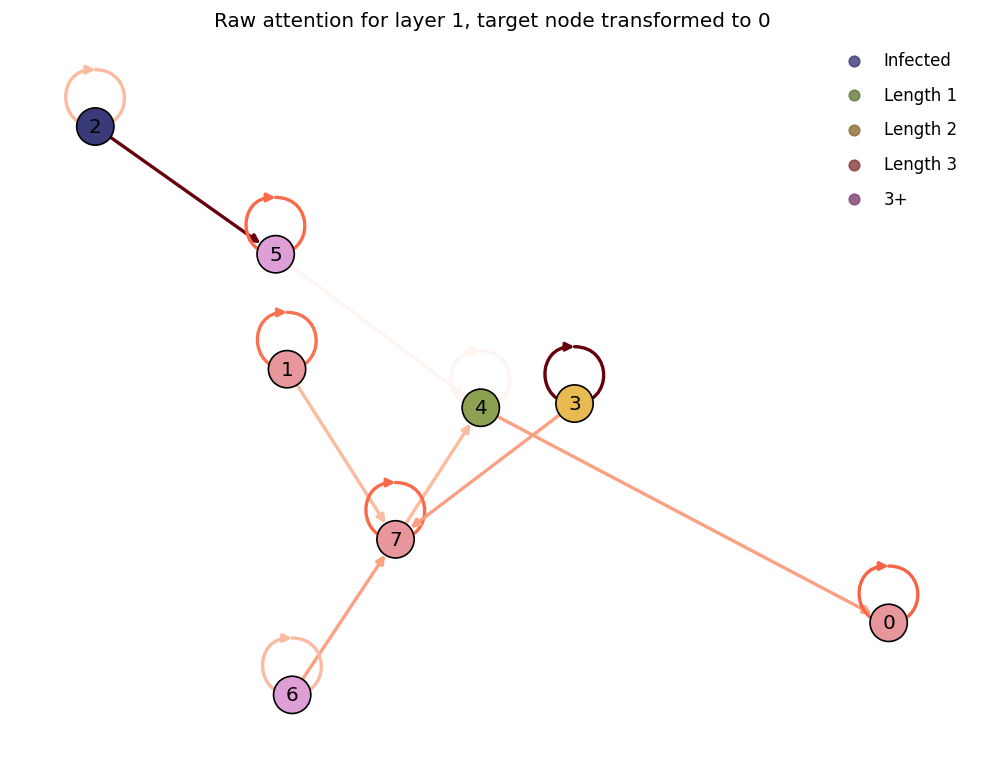

In [9]:
# Draw the graph with att_layer0 as edge weights
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(8, 6), dpi=120)
cmap = plt.cm.tab20b
edge_cmap = plt.cm.Reds
pos_loops = dict(zip(G_self_loops.nodes(), pos.values()))
nx.draw(G_self_loops, 
        pos=pos_loops,
        node_size=500,
        cmap=cmap,
        edge_color=edge_cmap(att_layer1),
        edge_vmin=0.0,
        edge_vmax=1.0,
        node_color=data.y[subset] / 5,
        edgecolors="black",
        with_labels=True, 
        width=2,
        font_weight='regular')
plt.title(f"Raw attention for layer 1, target node transformed to {mapping_loops.item()}")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0), label="Infected")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.2), label="Length 1")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.4), label="Length 2")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.6), label="Length 3")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.8), label="3+")
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc="upper right")
plt.show()

In [10]:
avgatt = ((att[0][1][edge_mask_loops].squeeze() + att[1][1][edge_mask_loops].squeeze())/2).tolist()


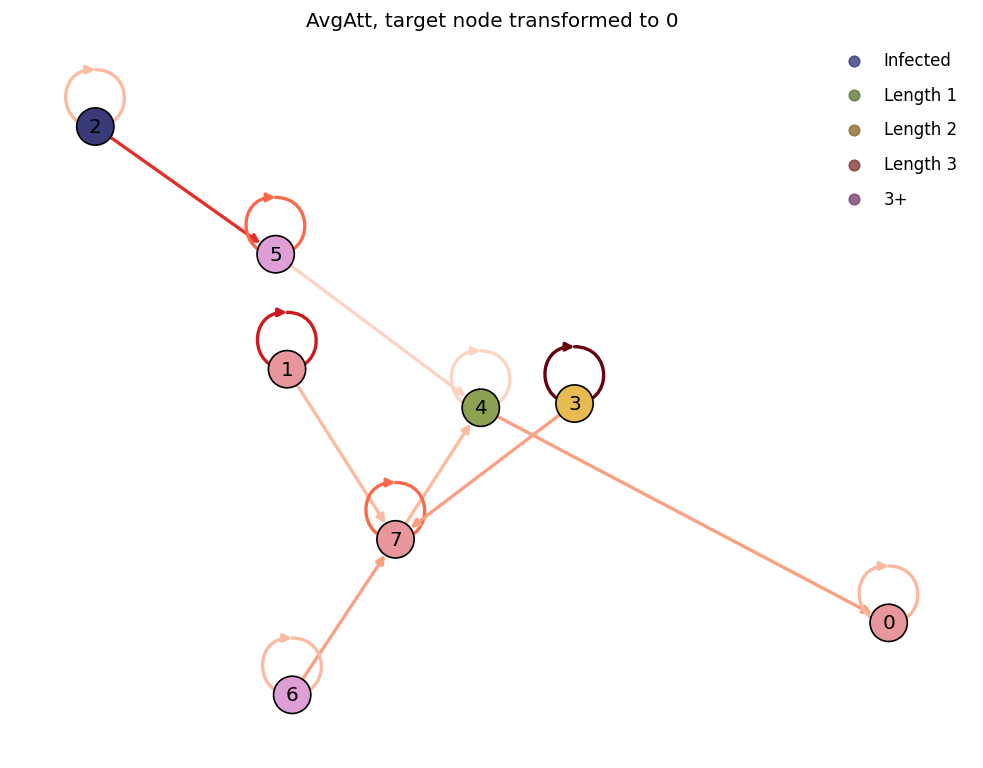

In [11]:
# Draw the graph with att_layer0 as edge weights
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(8, 6), dpi=120)
cmap = plt.cm.tab20b
edge_cmap = plt.cm.Reds
pos_loops = dict(zip(G_self_loops.nodes(), pos.values()))
nx.draw(G_self_loops, 
        pos=pos_loops,
        node_size=500,
        cmap=cmap,
        edge_color=edge_cmap(avgatt),
        edge_vmin=0.0,
        edge_vmax=1.0,
        node_color=data.y[subset] / 5,
        edgecolors="black",
        with_labels=True, 
        width=2,
        font_weight='regular')
plt.title(f"AvgAtt, target node transformed to {mapping_loops.item()}")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0), label="Infected")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.2), label="Length 1")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.4), label="Length 2")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.6), label="Length 3")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.8), label="3+")
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc="upper right")
plt.show()

In [12]:
# Now get the scores from ATTATTRIBUTE and ATTATTRIBUTE_sim
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    get_attention_raw_dict_multihead,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
    get_ATTATTTRIBUTE_edge,
    get_AVGATT_edge,
    return_edges_in_k_hop,
)
from typing import Tuple

def get_edge_scores(
    target_edge: Tuple, comp_graph, comp_graph_new, layer_att_dict, att
):
    assert type(target_edge) == tuple, "target_edge must be a tuple"
    # Get ATTATTRIBUTE & ATTATTRIBUTE_sim scores
    attattribute, attattribute_sim = get_ATTATTTRIBUTE_edge(
        comp_graph=comp_graph,
        comp_graph_new=comp_graph_new,
        layer_att_dict=layer_att_dict,
        target_edge=target_edge,
        verbose=False,
    )
    # Get AVGATT scores
    avgatt = get_AVGATT_edge(att=att, edge=target_edge)

    return attattribute, attattribute_sim, avgatt

num_layers = num_hops
att_dict_raw = get_attention_raw_dict_multihead(model, data)
att_dict = process_attention_dict(att_dict_raw)
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_idx
)
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)
comp_graph_new = translate_comp_graph(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
)
layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
)

edge_lists = return_edges_in_k_hop(
    data=data, target_idx=target_idx, hop=num_layers, self_loops=True
)

In [13]:
attattribute_list, attattribute_sim_list, avgatt_list = {}, {}, {}
for current_edge in edge_lists:
    attattribute, attattribute_sim, avgatt = get_edge_scores(
        target_edge=tuple(current_edge),
        comp_graph=comp_graph,
        comp_graph_new=comp_graph_new,
        layer_att_dict=layer_att_dict,
        att=att,
    )
    attattribute_list[tuple(current_edge)] = attattribute
    attattribute_sim_list[tuple(current_edge)] = attattribute_sim
    avgatt_list[tuple(current_edge)] = avgatt

In [14]:
translator = dict(zip(range(subset_loops.shape[0]), subset_loops.tolist()))

In [15]:
G_self_loops.edges()

OutEdgeView([(1, 7), (1, 1), (7, 4), (7, 7), (2, 5), (2, 2), (5, 4), (5, 5), (3, 7), (3, 3), (4, 0), (4, 4), (0, 0), (6, 7), (6, 6)])

In [16]:
curr_attattribute = []
curr_attattribute_sim = []
curr_avgatt = []

for curr_edge in G_self_loops.edges():
    edge1 = (translator[curr_edge[0]], translator[curr_edge[1]])
    # edge2 = (translator[curr_edge[1]], translator[curr_edge[0]])
    value1_attattr = attattribute_list[edge1]
    # value2_attattr = attattribute_list[edge2]
    value1_attattr_sim = attattribute_sim_list[edge1]
    # value2_attattr_sim = attattribute_sim_list[edge2]
    value1_avgatt = avgatt_list[edge1]
    # value2_avgatt = avgatt_list[edge2]

    curr_attattribute.append(value1_attattr)
    curr_attattribute_sim.append(value1_attattr_sim)
    curr_avgatt.append(value1_avgatt)

In [17]:
curr_attattribute = torch.tensor(curr_attattribute)
curr_attattribute_sim = torch.tensor(curr_attattribute_sim)
curr_avgatt = torch.tensor(curr_avgatt)

# curr_attattribute = curr_attattribute.exp()
# curr_attattribute_sim = curr_attattribute_sim.exp()
# curr_avgatt = curr_avgatt.exp()

curr_attattribute = curr_attattribute / curr_attattribute.max()
curr_attattribute_sim = curr_attattribute_sim / curr_attattribute_sim.max()
curr_avgatt = curr_avgatt / curr_avgatt.max()

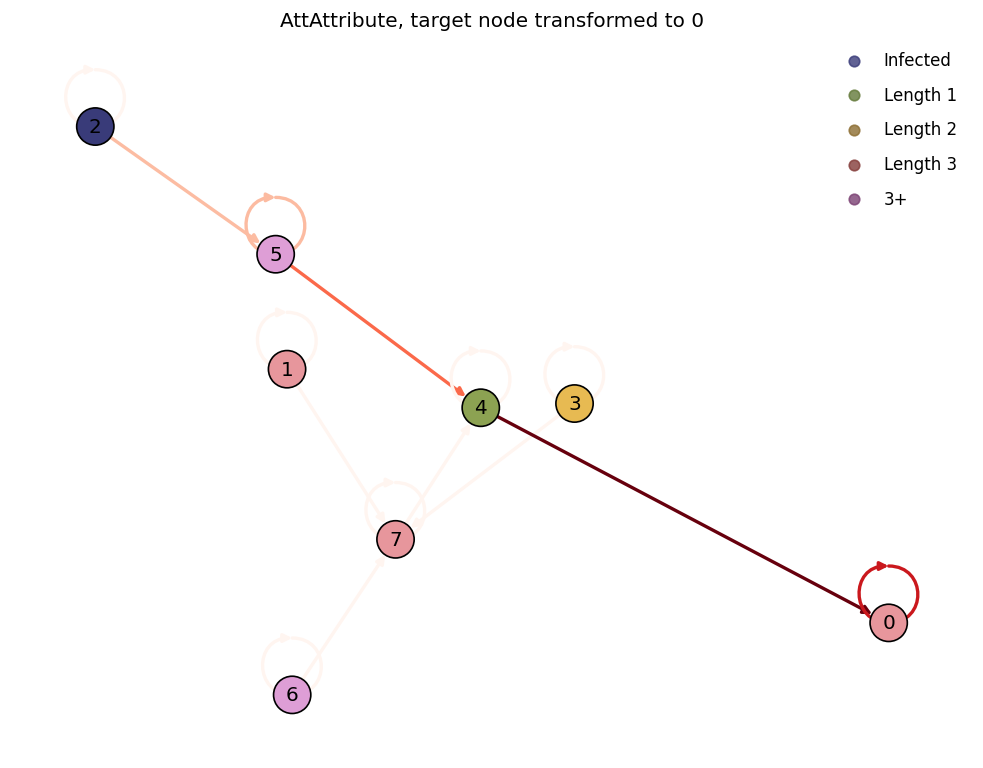

In [18]:
# Draw the graph with att_layer0 as edge weights
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(8, 6), dpi=120)
cmap = plt.cm.tab20b
edge_cmap = plt.cm.Reds
pos_loops = dict(zip(G_self_loops.nodes(), pos.values()))
nx.draw(G_self_loops, 
        pos=pos_loops,
        node_size=500,
        cmap=cmap,
        edge_color=edge_cmap(curr_attattribute),
        edge_vmin=0.0,
        # edge_vmax=curr_attattribute.max(),
        node_color=data.y[subset] / 5,
        edgecolors="black",
        with_labels=True, 
        width=2,
        font_weight='regular')
plt.title(f"AttAttribute, target node transformed to {mapping_loops.item()}")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0), label="Infected")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.2), label="Length 1")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.4), label="Length 2")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.6), label="Length 3")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.8), label="3+")
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc="upper right")
plt.show()

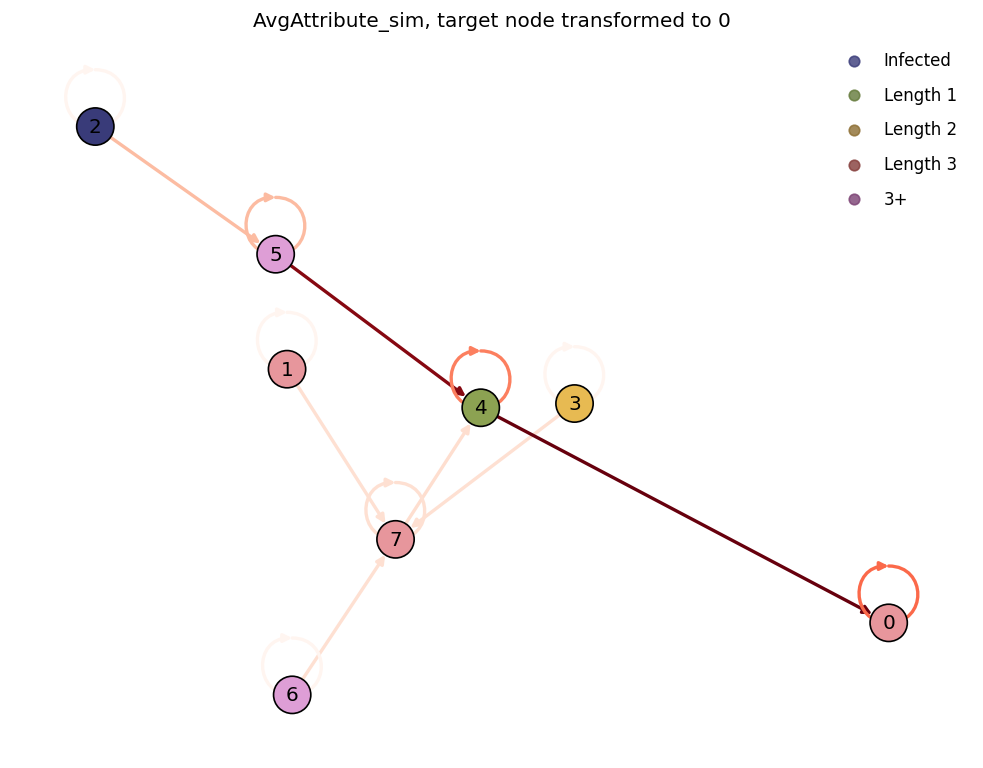

In [19]:
# Draw the graph with att_layer0 as edge weights
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(8, 6), dpi=120)
cmap = plt.cm.tab20b
edge_cmap = plt.cm.Reds
pos_loops = dict(zip(G_self_loops.nodes(), pos.values()))
nx.draw(G_self_loops, 
        pos=pos_loops,
        node_size=500,
        cmap=cmap,
        edge_color=edge_cmap(curr_attattribute_sim),
        edge_vmin=0.0,
        # edge_vmax=curr_attattribute_sim.max(),
        node_color=data.y[subset] / 5,
        edgecolors="black",
        with_labels=True, 
        width=2,
        font_weight='regular')
plt.title(f"AvgAttribute_sim, target node transformed to {mapping_loops.item()}")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0), label="Infected")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.2), label="Length 1")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.4), label="Length 2")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.6), label="Length 3")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.8), label="3+")
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc="upper right")
plt.show()

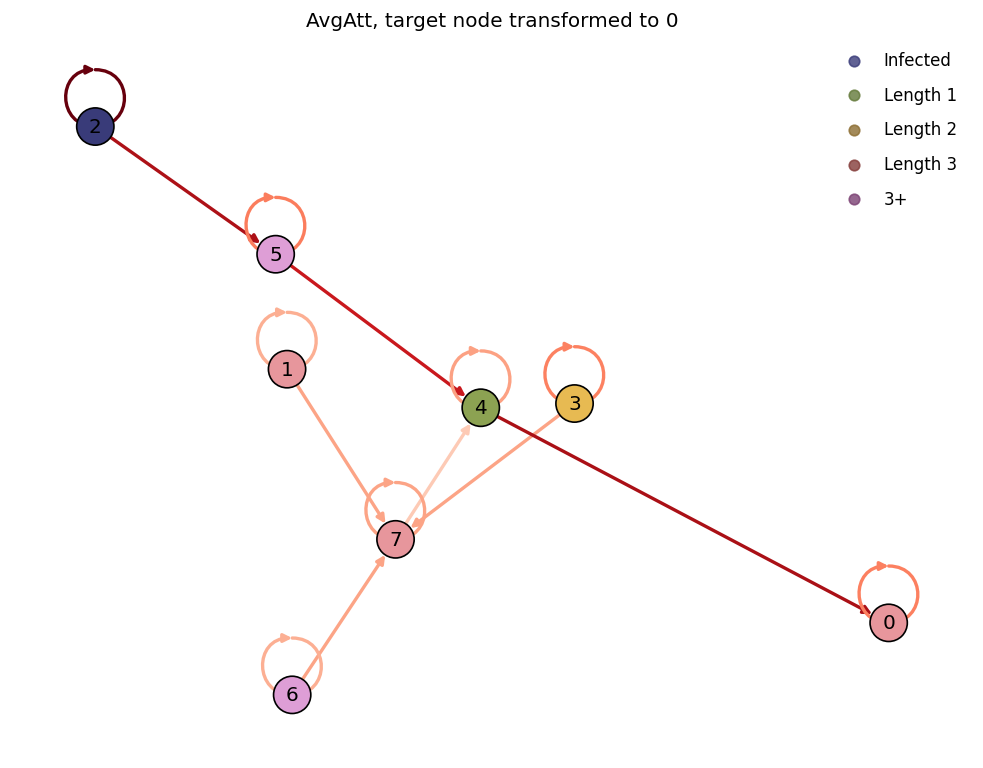

In [20]:
# Draw the graph with att_layer0 as edge weights
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(8, 6), dpi=120)
cmap = plt.cm.tab20b
edge_cmap = plt.cm.Reds
pos_loops = dict(zip(G_self_loops.nodes(), pos.values()))
nx.draw(G_self_loops, 
        pos=pos_loops,
        node_size=500,
        cmap=cmap,
        edge_color=edge_cmap(curr_avgatt),
        edge_vmin=0,
        # edge_vmax=curr_avgatt.max(),
        node_color=data.y[subset] / 5,
        edgecolors="black",
        with_labels=True, 
        width=2,
        font_weight='regular')
plt.title(f"AvgAtt, target node transformed to {mapping_loops.item()}")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0), label="Infected")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.2), label="Length 1")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.4), label="Length 2")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.6), label="Length 3")
plt.scatter([], [], alpha=0.8, s=40, color=cmap(0.8), label="3+")
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc="upper right")
plt.show()

In [ ]:
c